## Task 1 (10 Points)

Select padding sizes:

In [ ]:
import torch

N = 4
C = 3
C_out = 10
H = 8
W = 16

# p = (s * (out - 1) - in + k) // 2

x = torch.ones((N, C, H, W))

# torch.Size([4, 10, 8, 16])
out1 = torch.nn.Conv2d(C, C_out, kernel_size=(3, 3), padding=1)(x)
print(out1.shape) # for self-test

# torch.Size([4, 10, 8, 16])
out2 = torch.nn.Conv2d(C, C_out, kernel_size=(5, 5), padding=2)(x)
print(out2.shape) # for self-test

# torch.Size([4, 10, 8, 16])
out3 = torch.nn.Conv2d(C, C_out, kernel_size=(7, 7), padding=3)(x)
print(out3.shape) # for self-test

# torch.Size([4, 10, 8, 16])
out4 = torch.nn.Conv2d(C, C_out, kernel_size=(9, 9), padding=4)(x)
print(out4.shape) # for self-test

# torch.Size([4, 10, 8, 16])
out5 = torch.nn.Conv2d(C, C_out, kernel_size=(3, 5), padding=(1, 2))(x)
print(out5.shape) # for self-test

# torch.Size([4, 10, 22, 30])
out6 = torch.nn.Conv2d(C, C_out, kernel_size=(3, 3), padding=(8, 8))(x)
print(out6.shape) # for self-test

# torch.Size([4, 10, 7, 15])
out7 = torch.nn.Conv2d(C, C_out, kernel_size=(4, 4), padding=(1, 1))(x)
print(out7.shape) # for self-test

# torch.Size([4, 10, 9, 17])
out8 = torch.nn.Conv2d(C, C_out, kernel_size=(2, 2), padding=(1, 1))(x)
print(out8.shape) # for self-test

torch.Size([4, 10, 8, 16])
torch.Size([4, 10, 8, 16])
torch.Size([4, 10, 8, 16])
torch.Size([4, 10, 8, 16])
torch.Size([4, 10, 8, 16])
torch.Size([4, 10, 22, 30])
torch.Size([4, 10, 7, 15])
torch.Size([4, 10, 9, 17])


## Task 2 (40 Points)

## Step 0. Data preparation.

Article Link: https://arxiv.org/pdf/1602.07360v4.pdf

## Getting Dataset
* Set up Kaggle with the autentication file
* Download dataset from Kaggle


In [101]:
! pip install kaggle

ERROR: Operation cancelled by user


In [102]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [103]:
! cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' ~/.kaggle/

In [104]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d jessicali9530/stanford-cars-dataset

In [108]:
! cp -r '/content/stanford_cars' '/content/drive/MyDrive/Colab Notebooks/stanford_cars'

## Prepare Dataset in Pytorch

* Prepare dir structure following https://github.com/pytorch/vision/issues/7545 (download the dataset from kaggle, the devkit and cars_test_annos_withlabels.mat from the 3rd parties links; combine in one dir)

* Read with torchvision.datasets.StanfordCars pointing to dir with stanford-cars with download=False

* Normalize to 3x224x224 following https://jovian.com/mitchell-odili/stanford-cars

In [2]:
import torch
import torchvision
import random
import numpy as np
import matplotlib.pyplot as plt

In [10]:
cars_train = torchvision.datasets.StanfordCars(root='/content', download=False, split='train', transform=torchvision.transforms.ToTensor())
cars_test = torchvision.datasets.StanfordCars(root='/content', download=False, split='test', transform=torchvision.transforms.ToTensor())

In [118]:
cars_train

Dataset StanfordCars
    Number of datapoints: 8144
    Root location: /content
    StandardTransform
Transform: ToTensor()

In [123]:
image, label = cars_test[0]
print(image.shape, label)

torch.Size([3, 182, 276]) 180


In [124]:
image, label = cars_test[1]
print(image.shape, label)

torch.Size([3, 360, 640]) 102


In [125]:
cars_train.classes[label]

'Ferrari 458 Italia Convertible 2012'

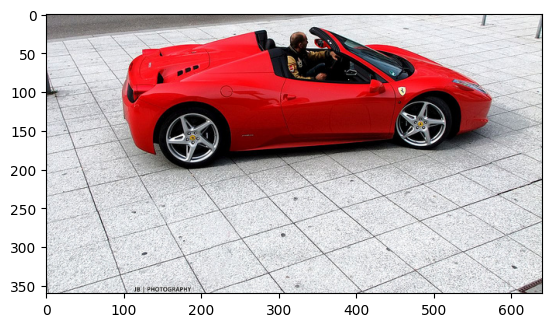

In [126]:
plt.imshow(image.permute(1, 2, 0))

In [11]:
# Normalize to 3x224x224
train_tfms = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
                                             torchvision.transforms.RandomRotation(0),
                                             torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [12]:
norm_cars_train = torchvision.datasets.StanfordCars(root='/content', download=False, split='train', transform=train_tfms)
norm_cars_test = torchvision.datasets.StanfordCars(root='/content', download=False, split='test', transform=test_tfms)

In [134]:
image, label = norm_cars_train[0]
print(image.shape, label)

torch.Size([3, 224, 224]) 13


In [135]:
norm_cars_train.classes[label]

'Audi TTS Coupe 2012'

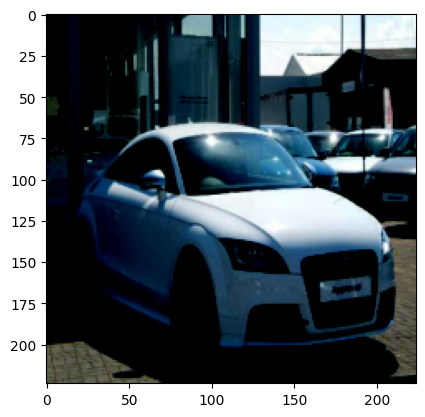

In [136]:
plt.imshow(image.permute(1, 2, 0))

In [ ]:
def get_data_and_target_tensors(dataset):
    data_list = []
    target_list = []

    for data, target in dataset:
        data_list.append(data)
        target_list.append(target)

    # Convert the lists to PyTorch tensors
    data_tensor = torch.stack(data_list)
    target_tensor = torch.tensor(target_list)
    return data_tensor, target_tensor

X_train, y_train = get_data_and_target_tensors(norm_cars_train)
X_test, y_test = get_data_and_target_tensors(norm_cars_test)

## Step 1. Neural network architecture

Develop an architecture according to the data from the article.
To test the functionality, test your architecture on any suitable data set.

### Architectural Design Strategies
**Strategy 1.** Replace 3×3 filters with 1×1 filters
Given a budget of a certain number of convolution filters, we can choose to make the majority of these filters 1×1, since a 1×1 filter has 9× fewer parameters than a 3×3 filter.

**Strategy 2.** Decrease the number of input channels to 3×3 filters
Consider a convolution layer that is comprised entirely of 3×3 filters. The total quantity of parameters in this layer is:
(number of input channels) × (number of filters) × (3×3)
We can decrease the number of input channels to 3×3 filters using squeeze layers, mentioned in the next section.

**Strategy 3.** Downsample late in the network so that convolution layers have large activation maps
The intuition is that large activation maps (due to delayed downsampling) can lead to higher classification accuracy.

### Fire Module
![](https://miro.medium.com/v2/resize:fit:930/format:webp/1*ONk0HfLLjDcUhUjuu8iq1w.png)
A Fire module is comprised of: a squeeze convolution layer (which has only 1×1 filters), feeding into an expand layer that has a mix of 1×1 and 3×3 convolution filters.

There are three tunable dimensions (hyperparameters) in a Fire module: s1×1, e1×1, and e3×3.

s1×1: The number of 1×1 in squeeze layer.

e1×1 and e3×3: The number of 1×1 and 3×3 in expand layer.

When we use Fire modules we set s1×1 to be less than (e1×1 + e3×3), so the squeeze layer helps to limit the number of input channels to the 3×3 filters, as per Strategy 2 in previous section.
To me, it is quite a like of Inception Module.

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*y87bqk95D-IndWdHM_K9-g.png)
![](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*XQGAKZb8kjoF_1lSXeIQxg.png)

In [8]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
class Fire(torch.nn.Module):

    def __init__(self, in_channels, s1x1, e1x1, e3x3):
        super(Fire, self).__init__()
        self.squeeze = torch.nn.Conv2d(in_channels, s1x1, kernel_size=1)
        self.squeeze_act = torch.nn.ReLU(inplace=True)
        self.expand1x1 = torch.nn.Conv2d(s1x1, e1x1, kernel_size=1)
        self.expand1x1_act = torch.nn.ReLU(inplace=True)
        self.expand3x3 = torch.nn.Conv2d(in_channels, e3x3, kernel_size=3, padding=1)
        self.expand3x3_act = torch.nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.squeeze_act(self.squeeze(x))
        return torch.cat([
            self.expand1x1_act(self.expand1x1(x)),
            self.expand3x3_act(self.expand3x3(x))
        ], 1)


class SqueezeNet(torch.nn.Module):
    def __init__(self):
        super(SqueezeNet, self).__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=96, kernel_size=7, stride=2, padding=1)
        self.act1 = torch.nn.ReLU(inplace=True)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=3, stride=2)

        self.fire2 = Fire(96, 16, 64, 64)
        self.fire3 = Fire(128, 16, 64, 64)
        self.fire4 = Fire(128, 16, 64, 64)
        self.pool4 = torch.nn.MaxPool2d(kernel_size=3, stride=2)

        self.fire5 = Fire(256, 32, 128, 128)
        self.fire6 = Fire(256, 48, 192, 192)
        self.fire7 = Fire(384, 48, 192, 192)
        self.fire8 = Fire(384, 64, 256, 256)
        self.pool8 = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=(0, 1))

        self.fire9 = Fire(512, 64, 256, 256)

        self.conv10 = torch.nn.Conv2d(in_channels=512, out_channels=1000, kernel_size=1, stride=1)
        self.pool10 = torch.nn.AvgPool2d(kernel_size=13, stride=1)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.fire2(x)
        x = self.fire3(x)
        x = self.fire4(x)
        x = self.pool4(x)

        x = self.fire5(x)
        x = self.fire6(x)
        x = self.fire7(x)
        x = self.fire8(x)
        x = self.pool8(x)

        x = self.fire9(x)

        x = self.conv10(x)
        x = self.pool10(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x

squeeze_net = SqueezeNet()

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
squeeze_net = squeeze_net.to(device)

## Step 2.  Loss Function

In [5]:
loss = torch.nn.CrossEntropyLoss()

## Step 3. Optimizer

In [6]:
optimizer = torch.optim.Adam(squeeze_net.parameters(), lr=0.001)

## Step 4. Train Loop

In [ ]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(1000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]

        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        preds = squeeze_net.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()

        optimizer.step()

    test_preds = squeeze_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())

    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)

    print(accuracy)

More efficient way with DataLoader (not finished)

In [ ]:
from torch.utils.data import DataLoader

# For norm_cars_train and norm_cars_test datasets

def custom_collate(batch):
    data, targets = zip(*batch)
    data = torch.stack(data, dim=0)
    targets = torch.tensor(targets)
    return data, targets

data_loader = DataLoader(norm_cars_train, batch_size=100, shuffle=True, collate_fn=custom_collate)

for data, targets in data_loader:
    pass